# [Introduction to Pyro](https://pyro.ai/examples/intro_long.html)

Once we have specified a model, Bayes’ rule tells us how to use it to perform inference, or draw conclusions about latent variables from data, by computing the posterior distribution over **z**:

$p_{\theta}({\bf z} | {\bf x}) = \frac{p_{\theta}({\bf x} , {\bf z})}{
\int \! d{\bf z}\; p_{\theta}({\bf x} , {\bf z}) }$

To check the results of modeling and inference, we would like to know how well a model fits observed data, which we can quantify with the **evidence** or **marginal likelihood**:

$p_{\theta}({\bf x}) = \int \! d{\bf z}\; p_{\theta}({\bf x} , {\bf z})$

and also to make predictions for new data, which we can do with the **posterior predictive distribution**:

$p_{\theta}(x' | {\bf x}) = \int \! d{\bf z}\; p_{\theta}(x' | {\bf z}) p_{\theta}({\bf z} | {\bf x})$

Finally, it is often desirable to **learn** the parameters of our models from observed data , which we can do by maximizing the marginal likelihood:

$\theta_{\rm{max}} = \rm{argmax}_\theta p_{\theta}({\bf x}) = \rm{argmax}_\theta \int \! d{\bf z}\; p_{\theta}({\bf x} , {\bf z})$.

In [1]:
%reset -s -f

import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.3')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

/home/koen/anaconda3/envs/PYRO/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example: Geography and national income

In [2]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]

In [3]:
df

,cont_africa,rugged,rgdppc_2000
0,0,0.462,NaN
1,0,2.518,NaN
2,1,0.858,1794.729
3,0,0.013,NaN
4,0,3.427,3703.113
...,...,...,...
229,0,1.677,4860.269
230,0,2.323,787.749
231,1,1.761,9419.122
232,1,0.533,774.010


In [4]:
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

/tmp/ipykernel_136341/3494630367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rgdppc_2000"] = np.log(df["rgdppc_2000"])


In [5]:
df

,cont_africa,rugged,rgdppc_2000
2,1,0.858,7.492609
4,0,3.427,8.216929
7,0,0.769,9.933263
8,0,0.775,9.407032
9,0,2.688,7.792343
...,...,...,...
229,0,1.677,8.488849
230,0,2.323,6.669180
231,1,1.761,9.150497
232,1,0.533,6.651585


In [6]:
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

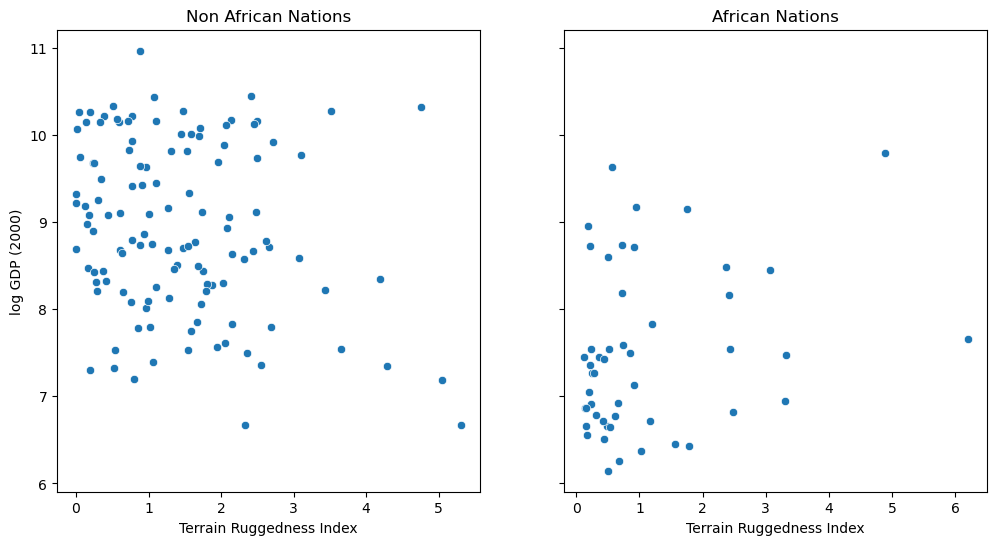

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

Specifically, the different mathematical pieces of model() are encoded via the mapping:

1 - latent random variables ($z$) pyro.sample

2 - observed random variables ($x$) pyro.sample with the obs keyword argument

3 - learnable parameters ($\theta$) - pyro.param

4 - plates - pyro.plate context managers

We examine each of these components in detail below in the context of a first Pyro model for linear regression.

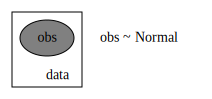

In [8]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def simple_model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.param("a", lambda: torch.randn(()))
    b_a = pyro.param("bA", lambda: torch.randn(()))
    b_r = pyro.param("bR", lambda: torch.randn(()))
    b_ar = pyro.param("bAR", lambda: torch.randn(()))
    sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True)

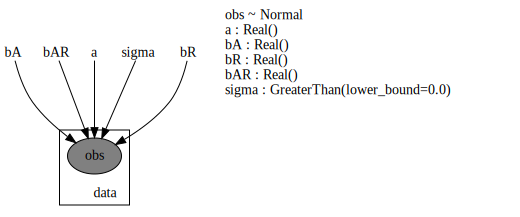

In [9]:
pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True, render_params=True)

## Background


### "Sample" primitive

```return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)``` in the model either represents a latent variable or observed variable, depending on whether the model is given a *log_gdp* value.

"However, note that when any sample statement is observed, the cumulative effect of every other sample statement in a model changes following Bayes’ rule; it is the job of Pyro’s inference algorithms to “run the program backwards” and assign mathematically consistent values to all pyro.sample statements in a model."

**Samples are thus either observed (_obs_) or latent random variables, stored in the _pyro.sample_ primitive.**

### "Param" primitive

The ```constraint``` object has a variety of in-built constraints on probability distributions for parameters in a model.

### "Plate" primitive

For [plate notation](https://en.wikipedia.org/wiki/Plate_notation) of models in probabilistic machine learning, for simplified analysis of models with lots of conditionally independent and identically distributed random variables.

## Example: from maximum-likelihood regression to Bayesian regression

"We simply replace ```pyro.param``` statements with ```pyro.sample``` statements equipped with Pyro Distribution objects discribing prior beliefs about each parameters."

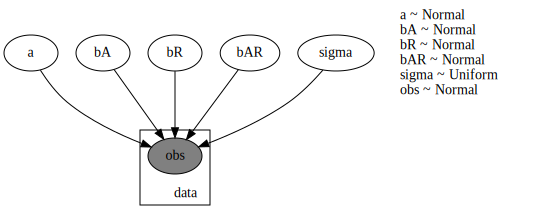

In [30]:
def model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True)

## Inference in Pyro

In [31]:
def custom_guide(is_cont_africa, ruggedness, log_gdp=None):
    a_loc = pyro.param('a_loc', lambda: torch.tensor(0.))
    a_scale = pyro.param('a_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', lambda: torch.randn(3))
    weights_scale = pyro.param('weights_scale', lambda: torch.ones(3),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    return {"a": a, "b_a": b_a, "b_r": b_r, "b_ar": b_ar, "sigma": sigma}


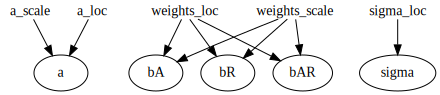

In [32]:
pyro.render_model(custom_guide, model_args=(is_cont_africa, ruggedness, log_gdp), render_params=True)

In [33]:
auto_guide = pyro.infer.autoguide.AutoNormal(model)

The functional of model $p_{\theta}({\bf x}, {\bf z})$ and guide $q_{\phi}({\bf z})$ that we will optimize is the ELBO, defined as an expectation w.r.t. to samples from the guide:

${\rm ELBO} \equiv \mathbb{E}_{q_{\phi}({\bf z})} \left [
\log p_{\theta}({\bf x}, {\bf z}) - \log q_{\phi}({\bf z})
\right]$

By assumption we can compute all of the probabilities inside the expectation, and since the guide $q$ is assumed to be a parametric distribution we can sample from, we can then compute Monte Carlo estimates of this quantity, as well as of gradients with respect to model and guide parameters, $\nabla_{\theta,\phi}ELBO$.

Optimizing the ELBO over model and guide parameters ${\theta,\phi}$ via stochastic gradient descent using these gradient estimates is sometimes called _stochastic variational inference_ (SVI).

In [34]:
adam = pyro.optim.Adam({'lr': 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

Here ```pyro.optim.Adam``` is a thin wrapper around the PyTorch optimizer ```torch.optim.Adam``` (see here for a discussion).

Optimizers in ```pyro.optim``` are used to optimize and update parameter values in Pyro’s parameter store.

In particular, you will notice that we do not need to pass in learnable parameters to the optimizer since that is determined by the guide code and happens behind the scenes within the ```SVI``` class automatically. 

To take an ELBO gradient step we simply call the step method of SVI. The data argument we pass to ```SVI.step``` will be passed to both ```model()``` and ```guide()```. The complete training loop is as follows:

Elbo loss: 694.5589399337769
Elbo loss: 531.0273870229721
Elbo loss: 472.16149282455444
Elbo loss: 406.6379472017288
Elbo loss: 317.12512969970703
Elbo loss: 252.93291944265366
Elbo loss: 251.93066108226776
Elbo loss: 248.77998542785645
Elbo loss: 250.17016088962555
Elbo loss: 247.98761290311813


CPU times: user 7.68 s, sys: 0 ns, total: 7.68 s
Wall time: 7.68 s


Text(0, 0.5, 'ELBO loss')

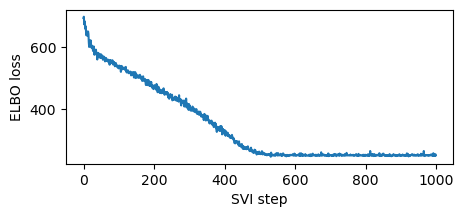

In [35]:
%%time
pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [36]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.a 9.202355
AutoNormal.scales.a 0.075758375
AutoNormal.locs.bA -1.8332708
AutoNormal.scales.bA 0.1567456
AutoNormal.locs.bR -0.17610914
AutoNormal.scales.bR 0.040428206
AutoNormal.locs.bAR 0.30700544
AutoNormal.scales.bAR 0.083750755
AutoNormal.locs.sigma -2.2317595
AutoNormal.scales.sigma 0.059767302


In [37]:
with pyro.plate("samples", 800, dim=-1):
    samples = auto_guide(is_cont_africa, ruggedness)

gamma_within_africa = samples["bR"] + samples["bAR"]
gamma_outside_africa = samples["bR"]

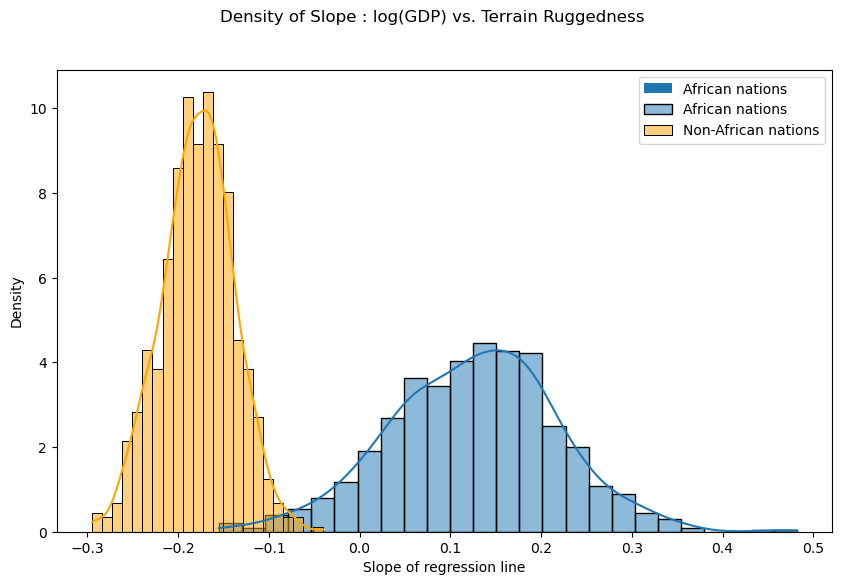

In [38]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(gamma_within_africa.detach().cpu().numpy(), kde=True, stat="density", label="African nations")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), kde=True, stat="density", label="Non-African nations", color="orange")
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");
plt.xlabel("Slope of regression line")
plt.legend()
plt.show()

## Model evaluation in Pyro

To assess whether we can trust the results of our inference, we will compare the posterior predictive distribution over possible new data induced by our model to the existing observed data. Computing this distribution is intractable in general because it depends on knowing the true posterior, but we can easily approximate it using our approximate posterior obtained from variational inference:
    
$p_{\theta}(x' | {\bf x}) = \int \! d{\bf z}\; p_{\theta}(x' | {\bf z}) p_{\theta}({\bf z} | {\bf x})
\approx \int \! d{\bf z}\; p_{\theta}(x' | {\bf z}) q_{\phi}({\bf z} | {\bf x})$

Concretely, to draw an approximate sample from the posterior predictive, we simply draw a sample ${\hat {\bf z}} \sim q_{\phi}({\bf z})$ from the approximate posterior, then sample from the distribution over observed variables in our model given that sample $x' \sim p_{\theta}(x | {\hat {\bf z}})$, as if we had replaced the prior with out (approximate) posterior).

To evaluate our example linear regression model, we’ll generate and visualize some samples from the posterior predictive distribution using the ```Predictive``` utility class, which implements the recipe above for sampling approximately from $p_{\theta}(x' | {\bf x})$.

We generate 800 samples from our trained model. Internally, this is done by first generating samples for the latent variables from the ```guide```, and then running the model forward while changing the values returned by unobserved ```pyro.sample``` statements to the corresponding values sampled from the ```guide```.

In [39]:
predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=800)
svi_samples = predictive(is_cont_africa, ruggedness, log_gdp=None)
svi_gdp = svi_samples['obs']

The code below is specific to this example and is simply used to plot the 90% credible interval (the interval containing 90% of the probability mass) of the posterior predictive distribution for each country.

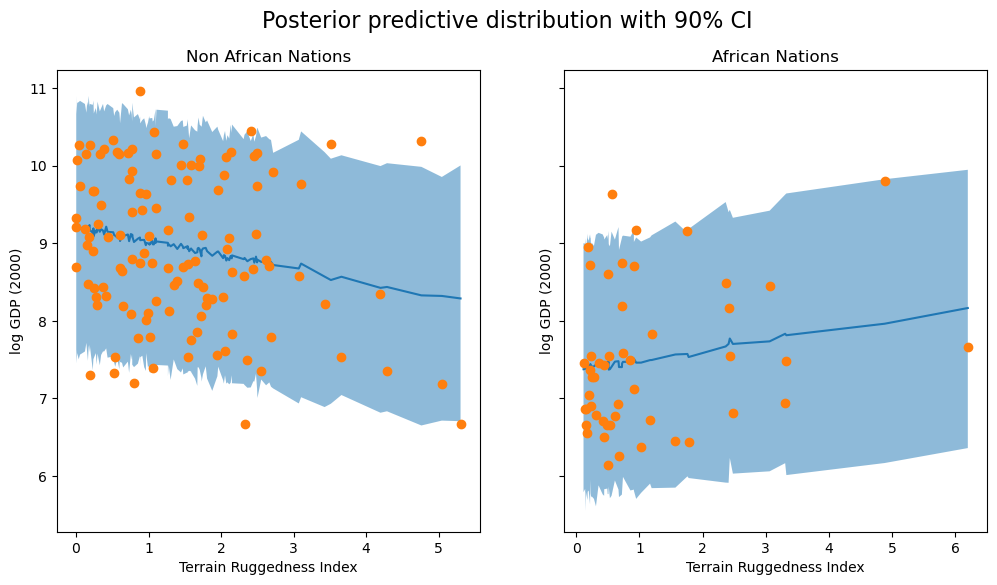

In [40]:
predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": svi_gdp.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_gdp.kthvalue(int(len(svi_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_gdp.kthvalue(int(len(svi_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_gdp": log_gdp,
})
african_nations = predictions[predictions["cont_africa"] == 1].sort_values(by=["rugged"])
non_african_nations = predictions[predictions["cont_africa"] == 0].sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], non_african_nations["y_perc_5"], non_african_nations["y_perc_95"], alpha=0.5)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations")

ax[1].plot(african_nations["rugged"], african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"], african_nations["y_perc_5"], african_nations["y_perc_95"], alpha=0.5)
ax[1].plot(african_nations["rugged"], african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="African Nations");

In [41]:
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)

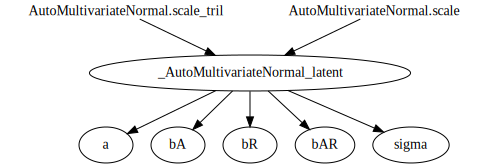

In [42]:
pyro.render_model(mvn_guide, model_args=(is_cont_africa, ruggedness, log_gdp), render_params=True)

Elbo loss: 952.4085947871208
Elbo loss: 646.7161419391632
Elbo loss: 600.5041723251343
Elbo loss: 588.8775308132172
Elbo loss: 548.8564089536667
Elbo loss: 510.12729823589325
Elbo loss: 453.05273139476776
Elbo loss: 379.8217171430588
Elbo loss: 297.1844630241394
Elbo loss: 246.91269433498383
Elbo loss: 252.8581948876381
Elbo loss: 247.75374388694763
Elbo loss: 248.1771439909935
Elbo loss: 247.95623058080673
Elbo loss: 247.7838271856308
Elbo loss: 247.7173770070076
Elbo loss: 247.40010797977448
Elbo loss: 248.27009415626526
Elbo loss: 248.08968305587769
Elbo loss: 248.07292520999908


CPU times: user 1min 18s, sys: 2.05 s, total: 1min 20s
Wall time: 20.9 s


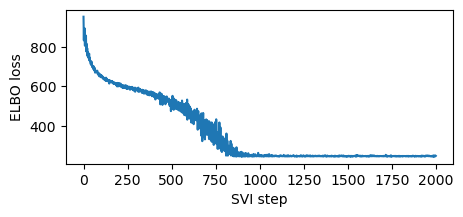

In [46]:
%%time
pyro.clear_param_store()
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
svi = pyro.infer.SVI(model,
                     mvn_guide,
                     pyro.optim.Adam({"lr": 0.02}),
                     pyro.infer.Trace_ELBO())

losses = []
for step in range(2000 if not smoke_test else 2):
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

with pyro.plate("samples", 800, dim=-1):
    mvn_samples = mvn_guide(is_cont_africa, ruggedness)

mvn_gamma_within_africa = mvn_samples["bR"] + mvn_samples["bAR"]
mvn_gamma_outside_africa = mvn_samples["bR"]

# Interface note: reuse guide samples for prediction by passing them to Predictive
# via the posterior_samples keyword argument instead of passing the guide as above
assert "obs" not in mvn_samples
mvn_predictive = pyro.infer.Predictive(model, posterior_samples=mvn_samples)
mvn_predictive_samples = mvn_predictive(is_cont_africa, ruggedness, log_gdp=None)

mvn_gdp = mvn_predictive_samples["obs"]

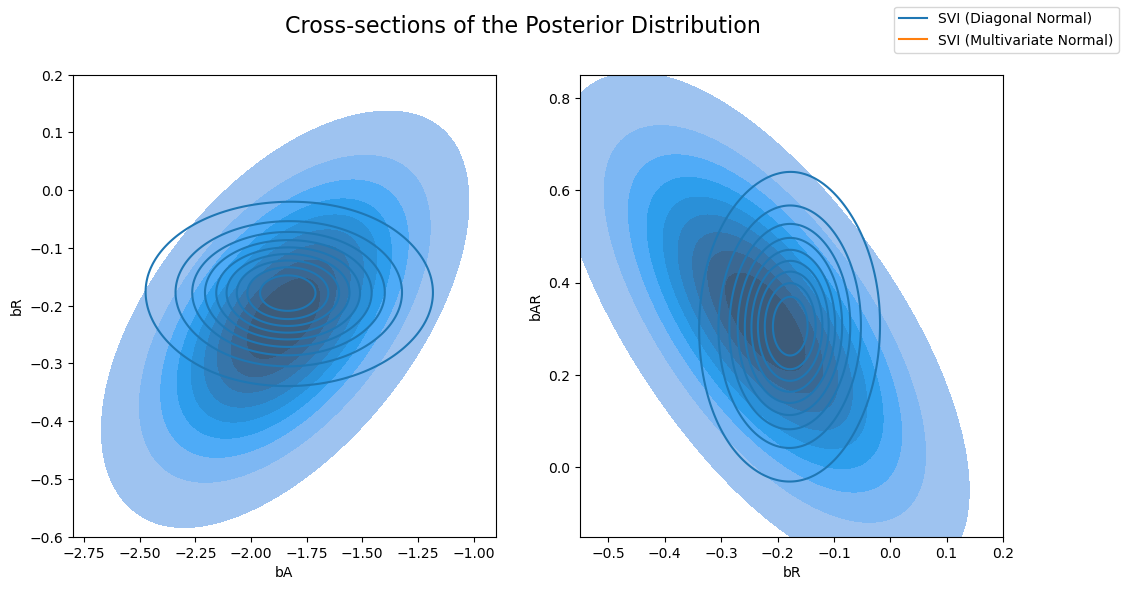

In [49]:
svi_samples = {k: v.detach().cpu().numpy() for k, v in samples.items()}
svi_mvn_samples = {k: v.detach().cpu().numpy() for k, v in mvn_samples.items()}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=svi_samples["bA"], y=svi_samples["bR"], ax=axs[0], bw_adjust=4 )
sns.kdeplot(x=svi_mvn_samples["bA"], y=svi_mvn_samples["bR"], ax=axs[0], fill=True, bw_adjust=4)
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.8, -0.9), ylim=(-0.6, 0.2))

sns.kdeplot(x=svi_samples["bR"], y=svi_samples["bAR"], ax=axs[1],bw_adjust=4 )
sns.kdeplot(x=svi_mvn_samples["bR"], y=svi_mvn_samples["bAR"], ax=axs[1], fill=True, bw_adjust=4)
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.55, 0.2), ylim=(-0.15, 0.85))


for label, color in zip(["SVI (Diagonal Normal)", "SVI (Multivariate Normal)"], sns.color_palette()[:2]):
    plt.plot([], [],
                label=label, color=color)

fig.legend(loc='upper right')


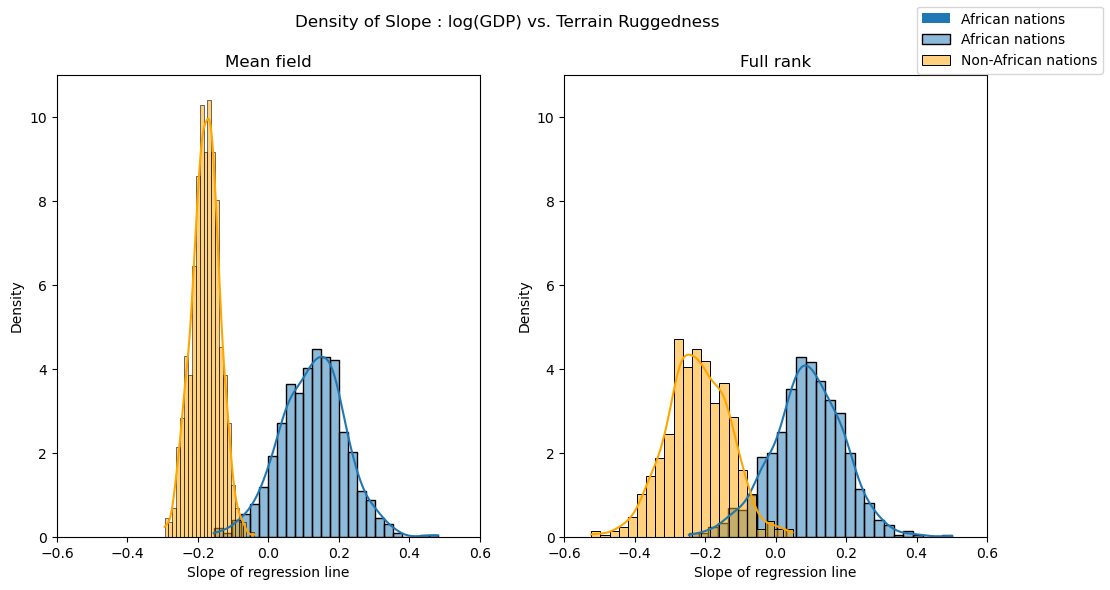

In [50]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");

sns.histplot(gamma_within_africa.detach().cpu().numpy(), ax=axs[0], kde=True, stat="density", label="African nations")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), ax=axs[0], kde=True, stat="density", color="orange", label="Non-African nations")
axs[0].set(title="Mean field", xlabel="Slope of regression line", xlim=(-0.6, 0.6), ylim=(0, 11))

sns.histplot(mvn_gamma_within_africa.detach().cpu().numpy(), ax=axs[1], kde=True, stat="density", label="African nations")
sns.histplot(mvn_gamma_outside_africa.detach().cpu().numpy(), ax=axs[1], kde=True, stat="density", color="orange", label="Non-African nations")
axs[1].set(title="Full rank", xlabel="Slope of regression line", xlim=(-0.6, 0.6), ylim=(0, 11))

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

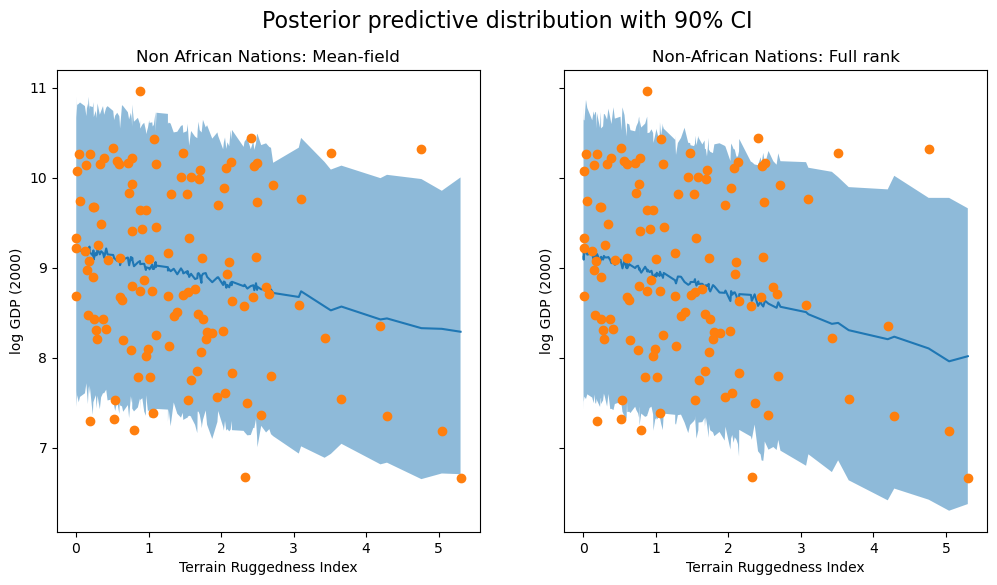

In [51]:
mvn_predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": mvn_gdp.mean(dim=0).detach().cpu().numpy(),
    "y_perc_5": mvn_gdp.kthvalue(int(len(mvn_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": mvn_gdp.kthvalue(int(len(mvn_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_gdp": log_gdp,
})
mvn_non_african_nations = mvn_predictions[mvn_predictions["cont_africa"] == 0].sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], non_african_nations["y_perc_5"], non_african_nations["y_perc_95"], alpha=0.5)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations: Mean-field")

ax[1].plot(mvn_non_african_nations["rugged"], mvn_non_african_nations["y_mean"])
ax[1].fill_between(mvn_non_african_nations["rugged"], mvn_non_african_nations["y_perc_5"], mvn_non_african_nations["y_perc_95"], alpha=0.5)
ax[1].plot(mvn_non_african_nations["rugged"], mvn_non_african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non-African Nations: Full rank");